In [1]:
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf

C:\Python\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Python\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Python\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Python\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1ty

In [2]:
data_dir = "word2voc_data/words"
data_url = "http://mattmahoney.net/dc/text8.zip"

In [3]:
def fetch_words_data(url=data_url, words_data=data_dir):
    # Make the Dir if it does not exist
    os.makedirs(words_data, exist_ok=True)

    # Path to zip file 
    zip_path = os.path.join(words_data, "words.zip")

    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)

    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])

    # Return a list of all the words in the data source.
    return data.decode("ascii").split()

In [4]:
words = fetch_words_data()

In [5]:
len(words)

17005207

In [6]:
words[9000:9040]

['feelings',
 'and',
 'the',
 'auditory',
 'system',
 'of',
 'a',
 'person',
 'without',
 'autism',
 'often',
 'cannot',
 'sense',
 'the',
 'fluctuations',
 'what',
 'seems',
 'to',
 'non',
 'autistic',
 'people',
 'like',
 'a',
 'high',
 'pitched',
 'sing',
 'song',
 'or',
 'flat',
 'robot',
 'like',
 'voice',
 'is',
 'common',
 'in',
 'autistic',
 'children',
 'some',
 'autistic',
 'children']

In [7]:
for w in words[9000:9040]:
    print(w, end=' ')

feelings and the auditory system of a person without autism often cannot sense the fluctuations what seems to non autistic people like a high pitched sing song or flat robot like voice is common in autistic children some autistic children 

In [8]:
from collections import Counter

In [9]:
my_list = ['one','Two','Two']

In [10]:
Counter(my_list)

Counter({'one': 1, 'Two': 2})

In [11]:
Counter(my_list).most_common(2)

[('Two', 2), ('one', 1)]

In [12]:
def create_counts(vocab_size=50000):
    
    vocab = [] + Counter(words).most_common(vocab_size)

    vocab = np.array([word for word, _ in vocab])

    dictionary = {word: code for code, word in enumerate(vocab)}
    data = np.array([dictionary.get(word, 0) for word in words])
    return data, vocab

In [13]:
data, vocab = create_counts()

In [14]:
data.shape

(17005207,)

In [15]:
vocab.shape

(50000,)

In [16]:
words[100]

'interpretations'

In [17]:
data[100]

4186

In [18]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [19]:
#constancts

In [20]:
batch_size = 128

In [21]:
embedding_size = 150

In [22]:
skip_window = 1

In [23]:
num_skips = 2

In [24]:
valid_size = 16
valid_window = 100

In [25]:
valid_example = np.random.choice(valid_window,valid_size,replace = False)

In [26]:
num_sample = 64

In [27]:
learning_rate = 0.01

In [28]:
vocab_size = 50000

In [29]:
tf.reset_default_graph()

In [30]:
train_inputs = tf.placeholder(tf.int32, shape = [None])
train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])

In [31]:
valid_dataset = tf.constant(valid_example, dtype = tf.int32)

In [32]:
init_embedding = tf.random_uniform([vocab_size,embedding_size],-1.0,1.0)

In [33]:
embedding = tf.Variable(init_embedding)

In [34]:
embed = tf.nn.embedding_lookup(embedding,train_inputs)

In [35]:
nce_weights = tf.Variable(tf.truncated_normal([vocab_size,embedding_size],stddev = 1.0 / np.sqrt(embedding_size)))

In [36]:
nce_bias = tf.Variable(tf.zeros([vocab_size]))

In [37]:
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights,nce_bias,train_labels,embed,num_sample,vocab_size))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [38]:
optimizer = tf.train.AdamOptimizer(1.0)

In [39]:
trainer = optimizer.minimize(loss)

In [40]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), axis=1, keepdims=True))
normalized_embeddings = embedding / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [41]:
data_index = 0

In [42]:
init = tf.global_variables_initializer()

In [43]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.7)

In [44]:
num_steps = 5000

In [45]:
with tf.Session(config = tf.ConfigProto(gpu_options = gpu_options)) as sess:
    
    sess.run(init)
    
    average_loss = 0
    
    for step in range(num_steps):
        
        batch_inputs ,batch_labels = generate_batch(batch_size, num_skips, skip_window)
        
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
#         sess.run([trainer, loss], feed_dict= feed_dict)
        
        _, loss_val = sess.run([trainer, loss], feed_dict= feed_dict)
        
#         average_loss = average_loss + loss_val
        average_loss += loss_val
    
        if step % 1000 == 0:
            
            if step > 0:
                average_loss = average_loss / 1000
            print("Avg loss at step ", step, "is: ", average_loss)

            average_loss= 0
            
        final_embeddings = normalized_embeddings.eval()

Avg loss at step  0 is:  278.6087646484375
Avg loss at step  1000 is:  10852.856872222901
Avg loss at step  2000 is:  22724.758627304076
Avg loss at step  3000 is:  27203.14018532181
Avg loss at step  4000 is:  31163.174732135773


In [46]:
from sklearn.manifold import TSNE

In [47]:
tsne = TSNE(perplexity=30,n_components=2,init = 'pca' , n_iter= 5000)

In [48]:
plot_only = 500

In [49]:
low_dim_embed = tsne.fit_transform(final_embeddings[:plot_only,:])

In [50]:
labels = [vocab[i] for i in range(plot_only)]

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

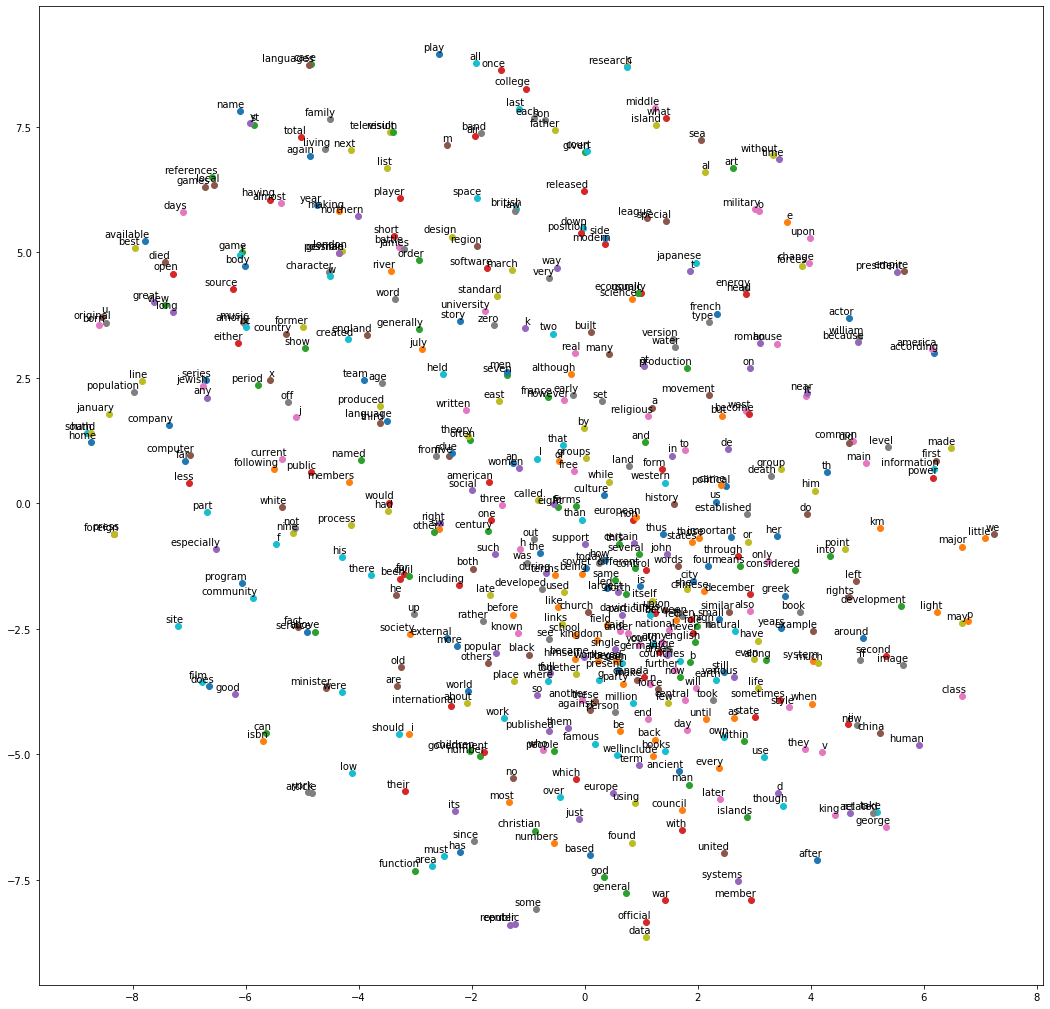

In [53]:
plot_with_labels(low_dim_embed, labels)